<a href="https://colab.research.google.com/github/12ljw/deep-learning-with-python-2nd/blob/main/AI_Thumbnail_Selector_CLIP_TrainingFree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Training‑Free AI Thumbnail Selector (CLIP)

유튜브 **영상 제목(텍스트)**과 **추출 프레임(이미지)** 간 의미 유사도를 계산해, *학습 없이* 베스트 썸네일을 추천하는 노트북입니다.

**Pipeline**
1) ffmpeg로 10초 간격 프레임 추출  
2) CLIP 임베딩으로 제목–이미지 유사도 계산  
3) Top‑k 썸네일 추천 (+ 선택: 유사 프레임 중복 제거)


In [19]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [20]:

# !pip install -q transformers pillow imagehash ftfy regex tqdm
import os, glob, math, shutil
from PIL import Image
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import imagehash
from IPython.display import display, HTML

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_id = 'openai/clip-vit-base-patch32'
model = CLIPModel.from_pretrained(model_id).to(device)
proc  = CLIPProcessor.from_pretrained(model_id)
print('Device:', device)


Device: cuda


In [ ]:
# !pip install -q yt-dlp

In [ ]:
# 1) YouTube 다운로드 설정
!pip install -q yt-dlp
import yt_dlp

YOUTUBE_URL = 'https://www.youtube.com/watch?v=U4NZllj854o'
OUTPUT_MP4 = 'input.mp4'

ydl_opts = {
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
    'merge_output_format': 'mp4',
    'outtmpl': 'yt_download.%(ext)s',
    'noplaylist': True,
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(YOUTUBE_URL, download=True)
    downloaded = ydl.prepare_filename(info)


if os.path.exists(OUTPUT_MP4):
    os.remove(OUTPUT_MP4)
shutil.move(downloaded if os.path.exists(downloaded) else 'yt_download.mp4', OUTPUT_MP4)
print('다운로드 완료:', OUTPUT_MP4)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.1 MB/s eta 0:00:00
[youtube] Extracting URL: https://www.youtube.com/watch?v=U4NZllj854o
[youtube] U4NZllj854o: Downloading webpage
[youtube] U4NZllj854o: Downloading android sdkless player API JSON
[youtube] U4NZllj854o: Downloading tv client config
[youtube] U4NZllj854o: Downloading player c6d7bdc9-main
[youtube] U4NZllj854o: Downloading tv player API JSON
[youtube] U4NZllj854o: Downloading web safari player API JSON


         player = https://www.youtube.com/s/player/c6d7bdc9/player_ias.vflset/en_US/base.js
         n = p19XZqetGGXdnvuj ; player = https://www.youtube.com/s/player/c6d7bdc9/player_ias.vflset/en_US/base.js
         Please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U


[youtube] U4NZllj854o: Downloading m3u8 information
[info] U4NZllj854o: Downloading 1 format(s): 401+140-8
[download] Sleeping 3.00 seconds as required by the site...
[download] Destination: yt_download.f401.mp4
[download] 100% of  581.77MiB in 00:00:16 at 35.00MiB/s  
[download] Destination: yt_download.f140-8.m4a
[download] 100% of   17.83MiB in 00:00:00 at 42.07MiB/s  
[Merger] Merging formats into "yt_download.mp4"
Deleting original file yt_download.f401.mp4 (pass -k to keep)
Deleting original file yt_download.f140-8.m4a (pass -k to keep)
다운로드 완료: input.mp4


In [ ]:
# 2) 프레임 추출 (ffmpeg)
interval_sec = 10   # 10초 간격
out_dir = 'frames'
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir, exist_ok=True)

fps_expr = f'1/{interval_sec}'
cmd = f"ffmpeg -i '{OUTPUT_MP4}' -vf fps={fps_expr} -qscale:v 2 {out_dir}/frame_%05d.jpg -hide_banner -loglevel error"
print('실행:', cmd)
ret = os.system(cmd)
assert ret == 0, 'ffmpeg 실행 실패. 다른 영상으로 테스트해보세요.'
frame_paths = sorted(glob.glob(f'{out_dir}/frame_*.jpg'))
print('추출 프레임 수:', len(frame_paths))
assert len(frame_paths) > 0, '프레임이 추출되지 않았습니다.'


실행: ffmpeg -i 'input.mp4' -vf fps=1/10 -qscale:v 2 frames/frame_%05d.jpg -hide_banner -loglevel error
추출 프레임 수: 116


In [ ]:
# 3) 유사 프레임 중복 제거: pHash
enable_dedup = True
dedup_threshold = 6

def dedup_by_phash(paths, threshold=6):
    kept = []
    hashes = []
    for p in paths:
        h = imagehash.phash(Image.open(p).convert('RGB'))
        is_dup = any(abs(h - hh) <= threshold for hh in hashes)
        if not is_dup:
            kept.append(p)
            hashes.append(h)
    return kept

if enable_dedup:
    before = len(frame_paths)
    frame_paths = dedup_by_phash(frame_paths, threshold=dedup_threshold)
    print(f'중복 제거: {before} → {len(frame_paths)}')


중복 제거: 116 → 109


In [ ]:
# 4) 영상 제목 입력
title = '5 Restaurant Quality Pasta Sauces in 15 Minutes'
print('제목:', title)


제목: 5 Restaurant Quality Pasta Sauces in 15 Minutes


In [ ]:
# 5) CLIP 임베딩 & 유사도 계산
def embed_text(text):
    with torch.no_grad():
        x = proc(text=[text], return_tensors='pt', padding=True).to(device)
        t = model.get_text_features(**x)
        t = t / t.norm(dim=-1, keepdim=True)
    return t

def embed_images(paths):
    imgs = [Image.open(p).convert('RGB') for p in paths]
    with torch.no_grad():
        x = proc(images=imgs, return_tensors='pt')
        x = {k:v.to(device) for k,v in x.items()}
        v = model.get_image_features(**x)
        v = v / v.norm(dim=-1, keepdim=True)
    return v

t = embed_text(title)
v = embed_images(frame_paths)
scores = (v @ t.T).squeeze(1).cpu().numpy()
order = np.argsort(-scores)
topk = 5
top_idx = order[:topk]
results = [(frame_paths[i], float(scores[i])) for i in top_idx]
for i,(p,s) in enumerate(results,1):
    print(f'Top{i}: {p}  score={s:.3f}')


Top1: frames/frame_00027.jpg  score=0.330
Top2: frames/frame_00046.jpg  score=0.316
Top3: frames/frame_00013.jpg  score=0.315
Top4: frames/frame_00018.jpg  score=0.315
Top5: frames/frame_00009.jpg  score=0.314


In [ ]:
# 6) 결과 시각화 + 타임스탬프 + 베스트 저장
'''
import re

def path_to_seconds(p, interval=10):
    m = re.search(r'(\d+)', os.path.basename(p))
    idx = int(m.group(1)) if m else 1
    return (idx-1) * interval

def sec_to_hms(sec):
    h = sec // 3600; m = (sec % 3600) // 60; s = sec % 60
    return f"{int(h):02d}:{int(m):02d}:{int(s):02d}"

html = ["<h3>Top‑5 Recommended Thumbnails</h3>"]
best_path = None
for rank,(p,s) in enumerate(results,1):
    ts = sec_to_hms(path_to_seconds(p, interval_sec))
    if rank == 1:
        best_path = p
    html.append(f"<div><b>Top{rank}</b> | score={s:.3f} | time={ts}<br><img src='{p}' width='480'></div><hr>")
display(HTML(''.join(html)))

if best_path:
    os.makedirs('output', exist_ok=True)
    out_best = 'output/best_thumbnail.jpg'
    Image.open(best_path).save(out_best)
    print('베스트 썸네일 저장:', out_best)

'''

베스트 썸네일 저장: output/best_thumbnail.jpg


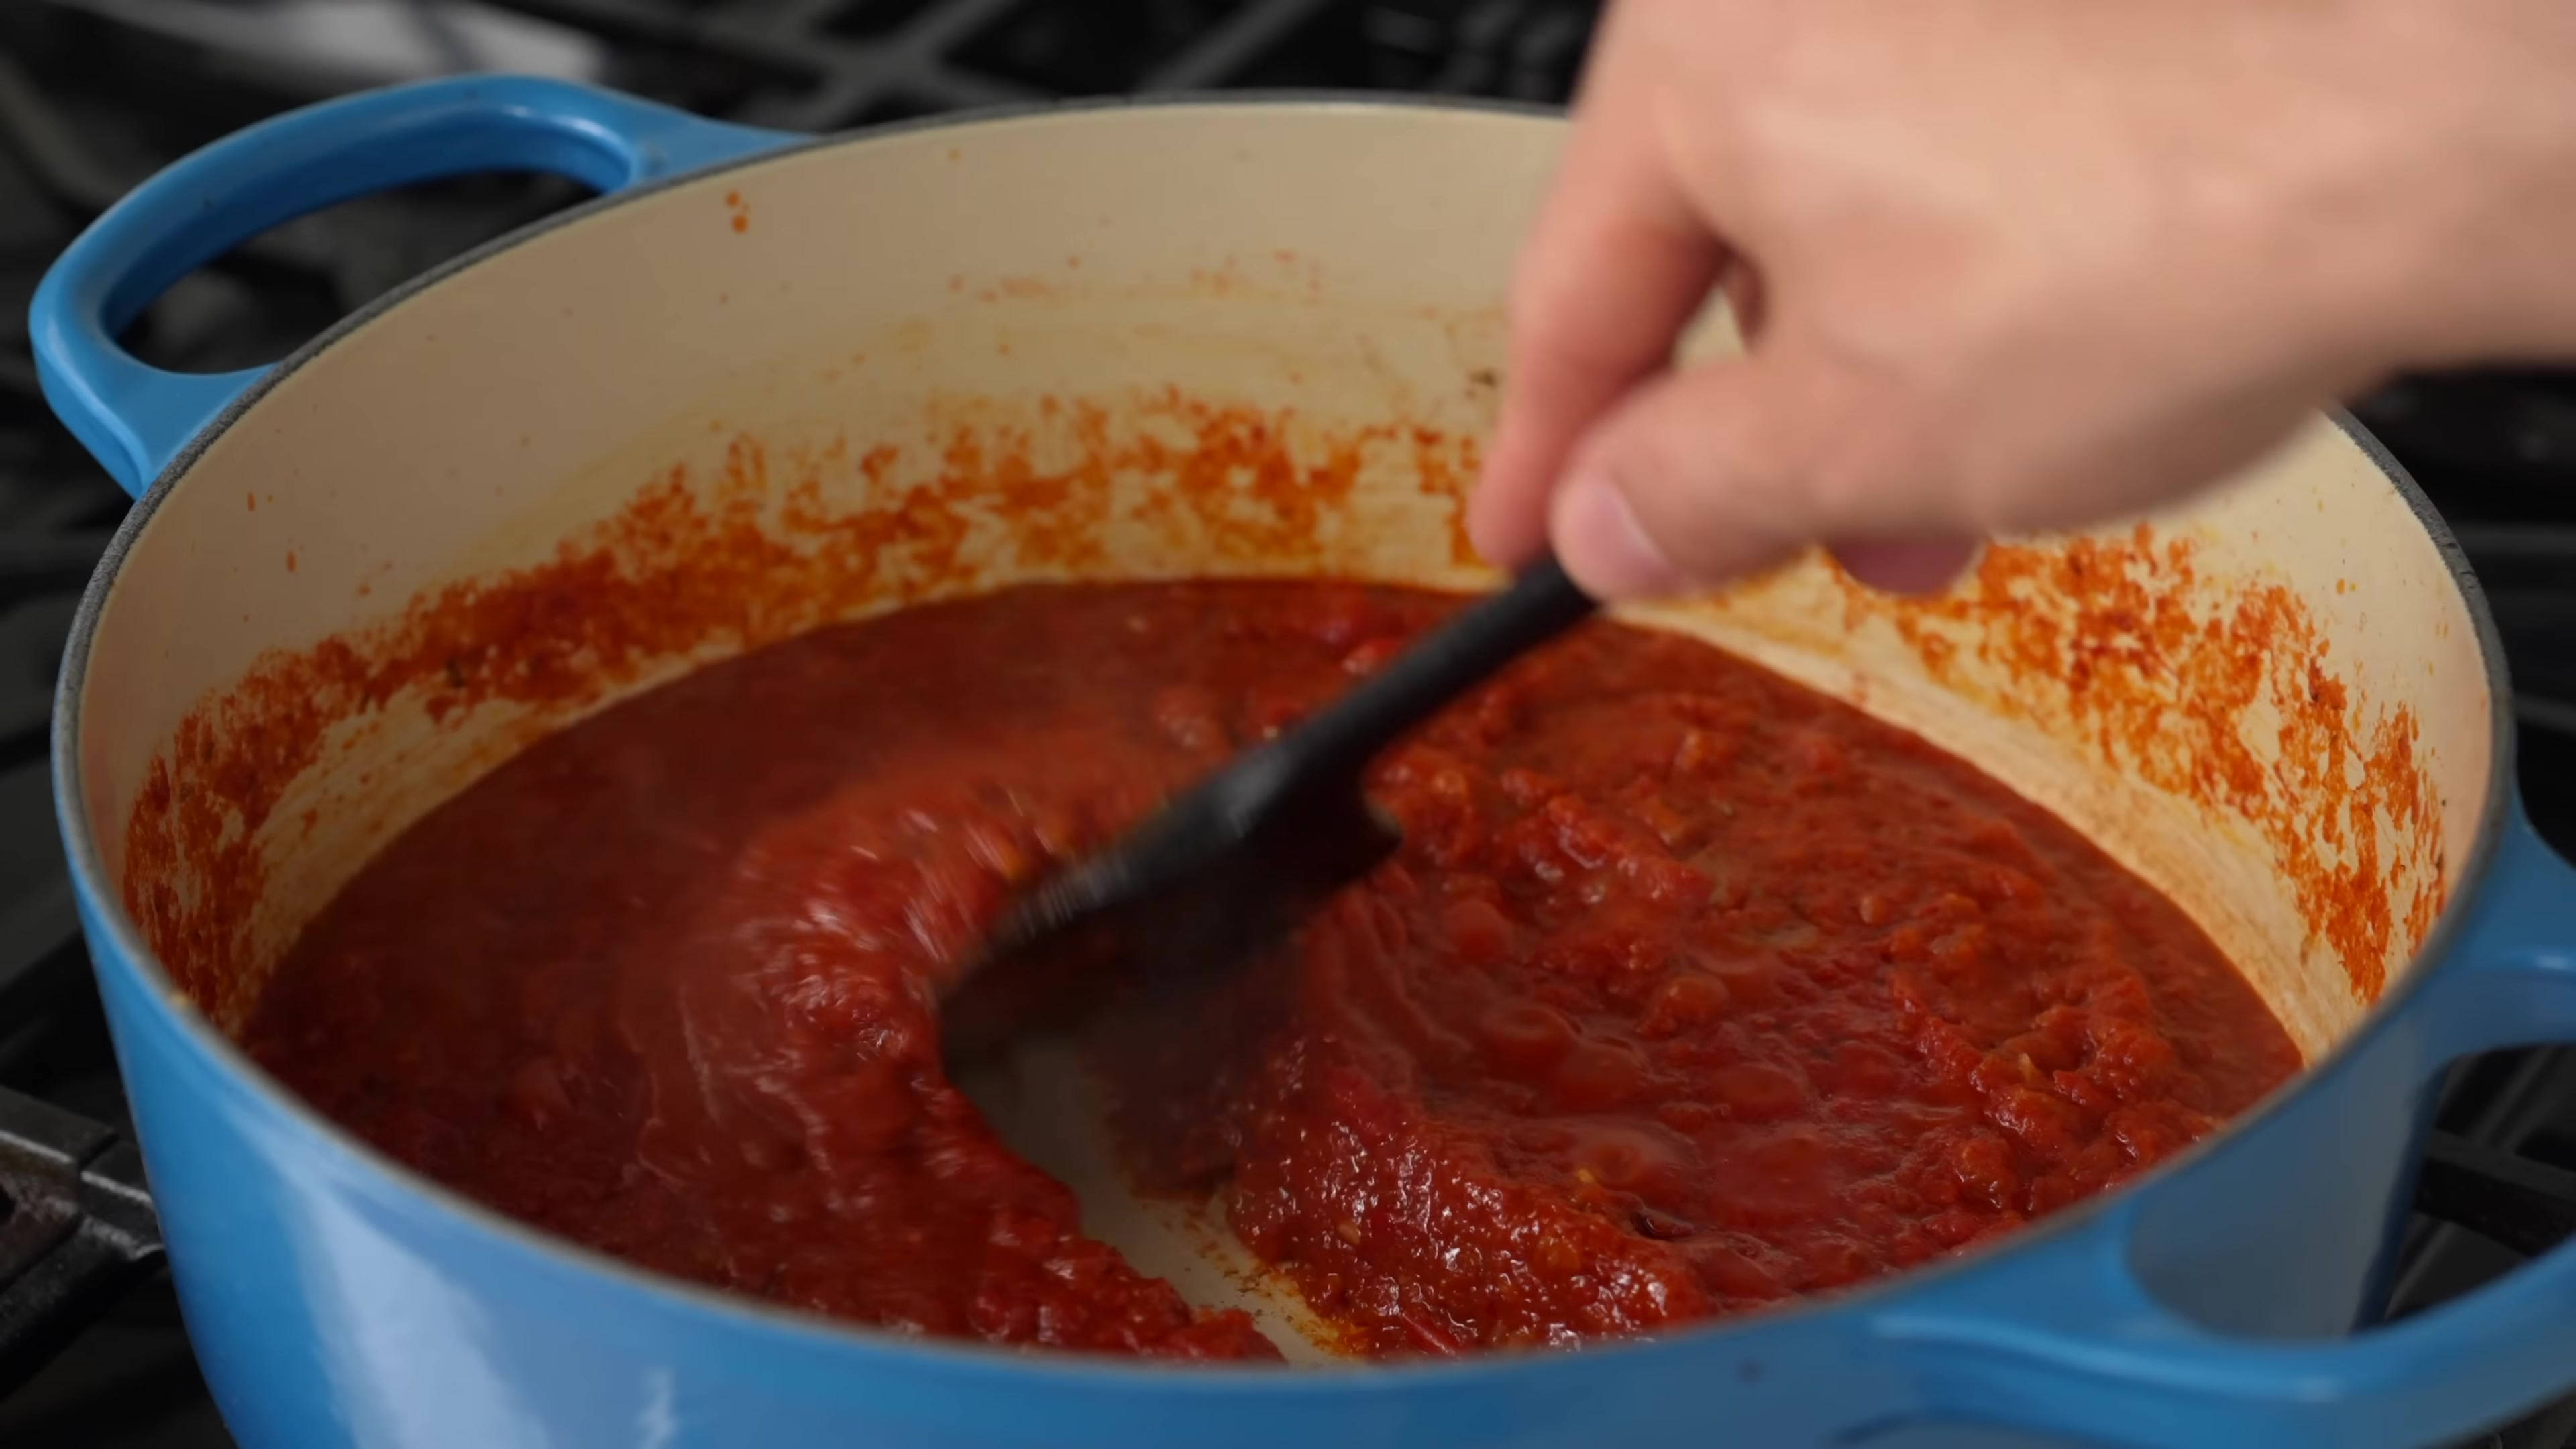

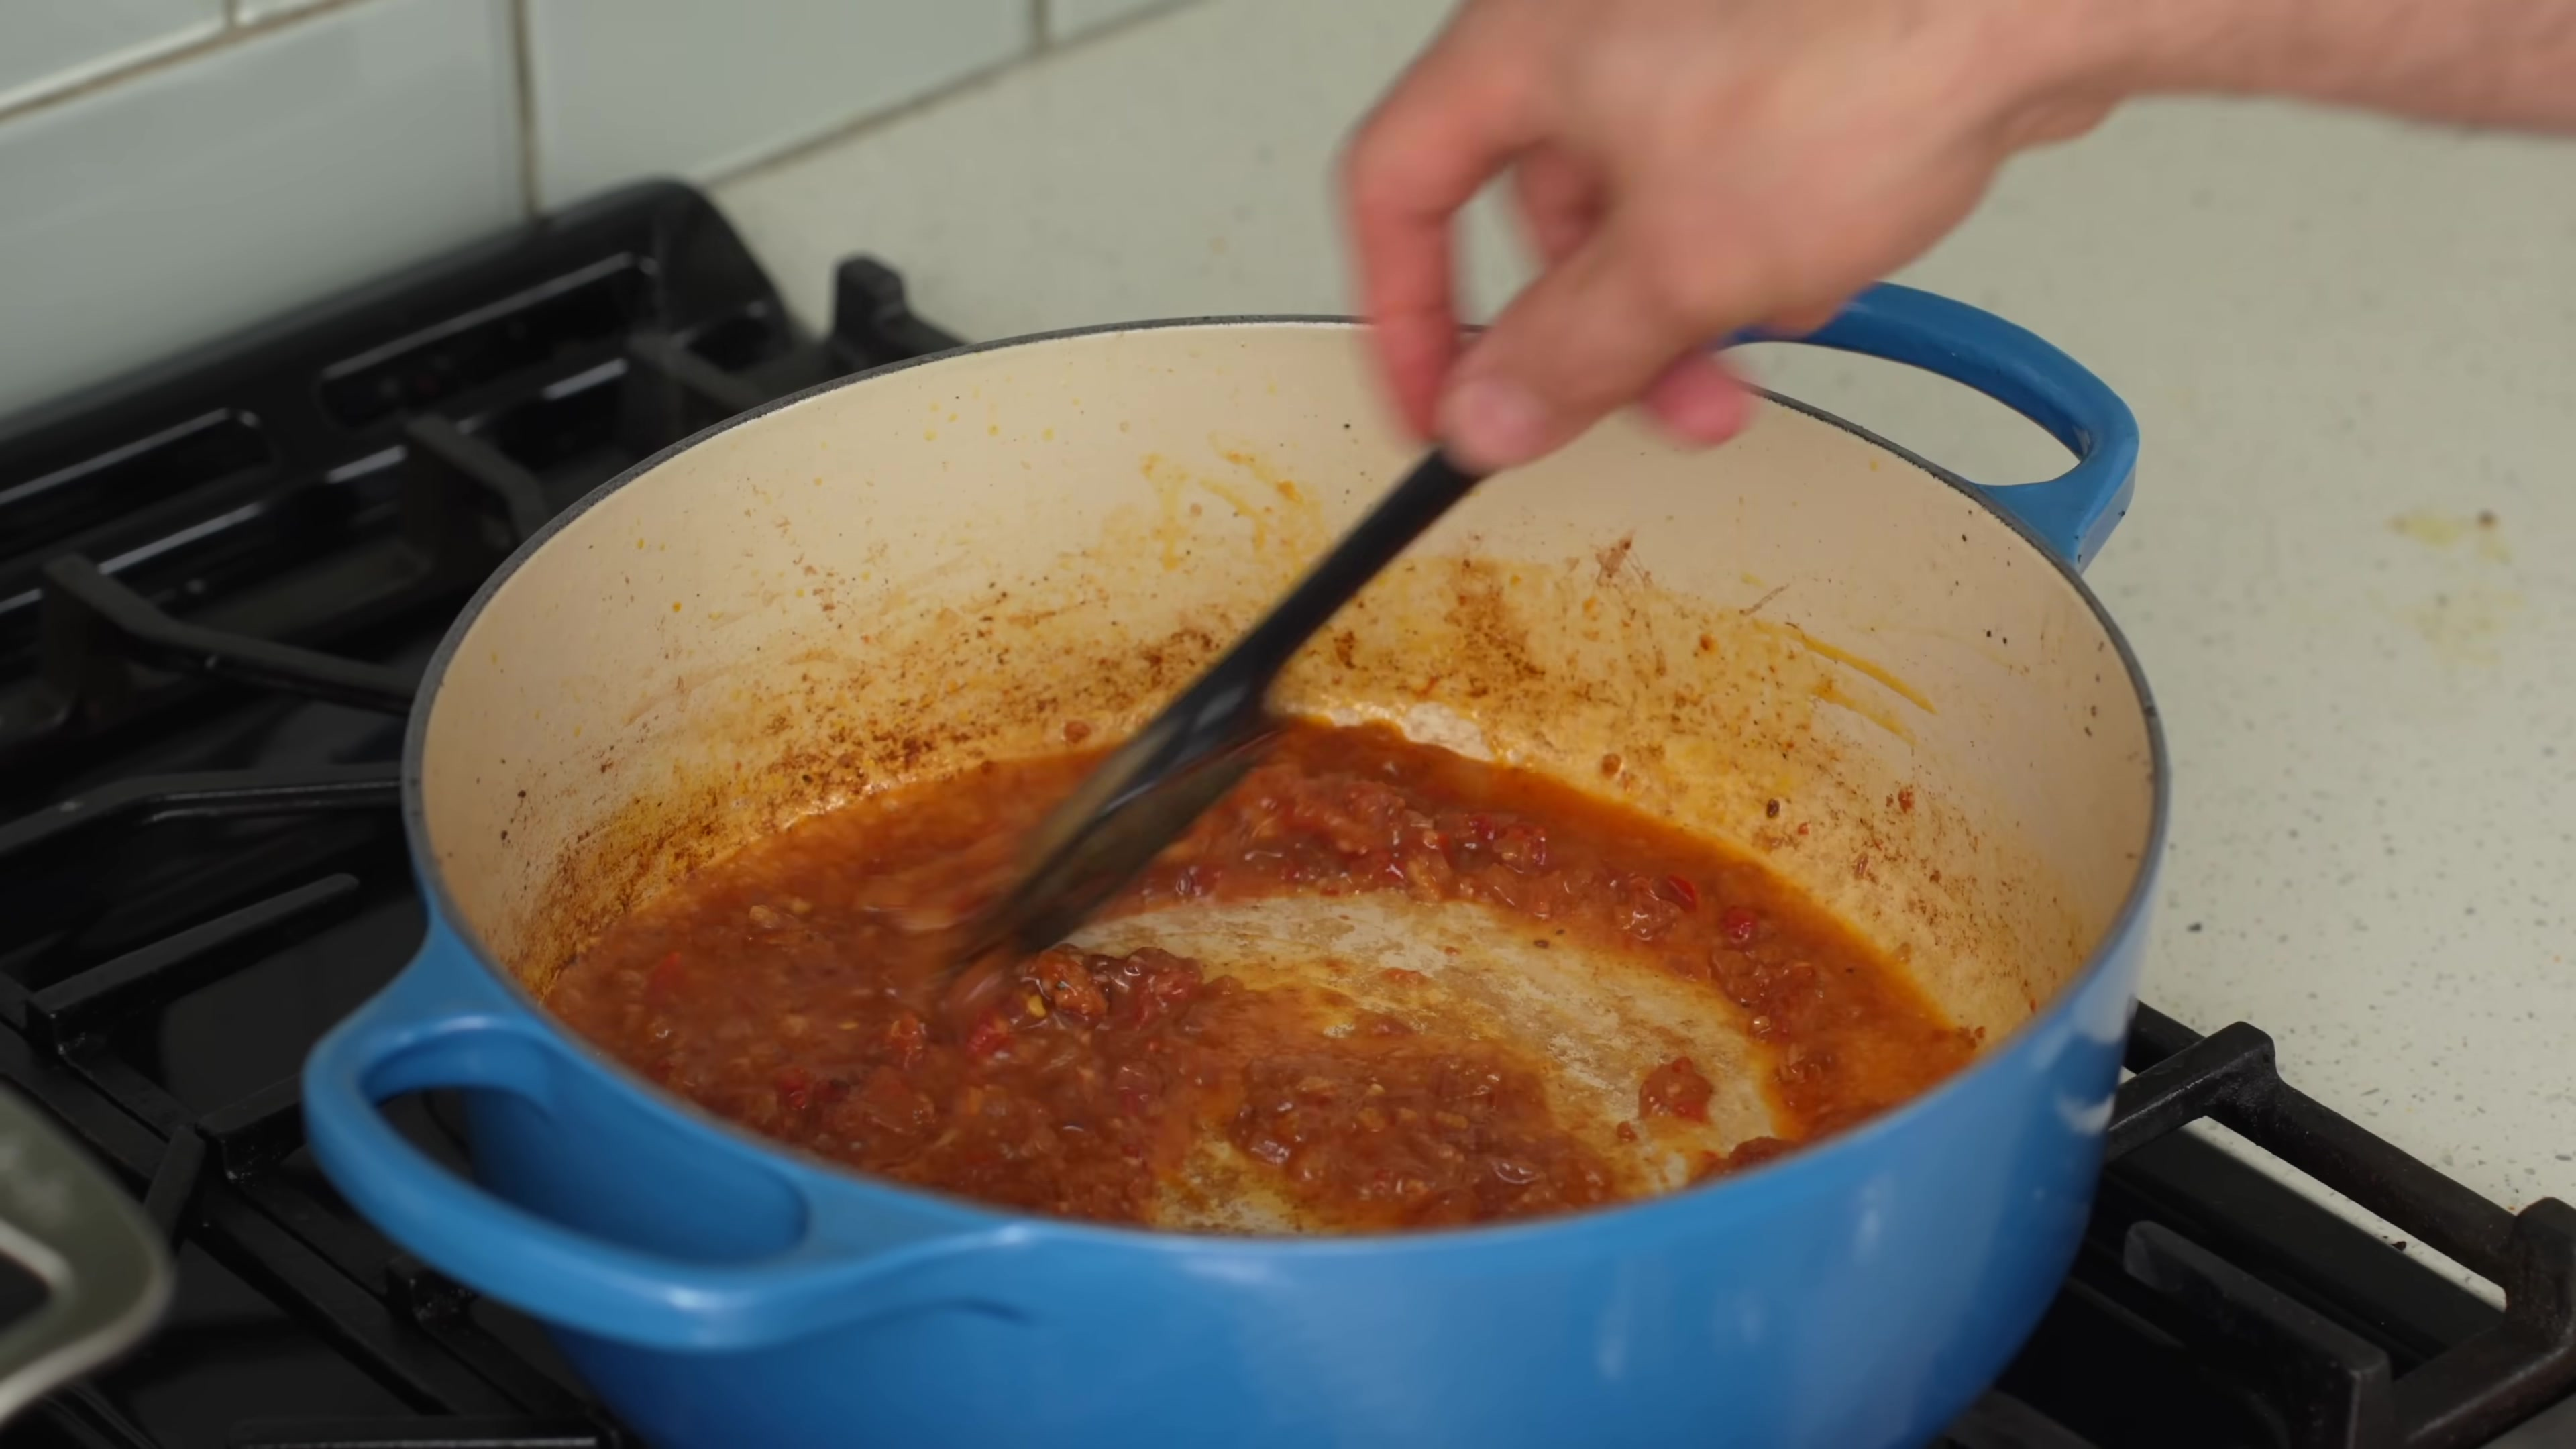

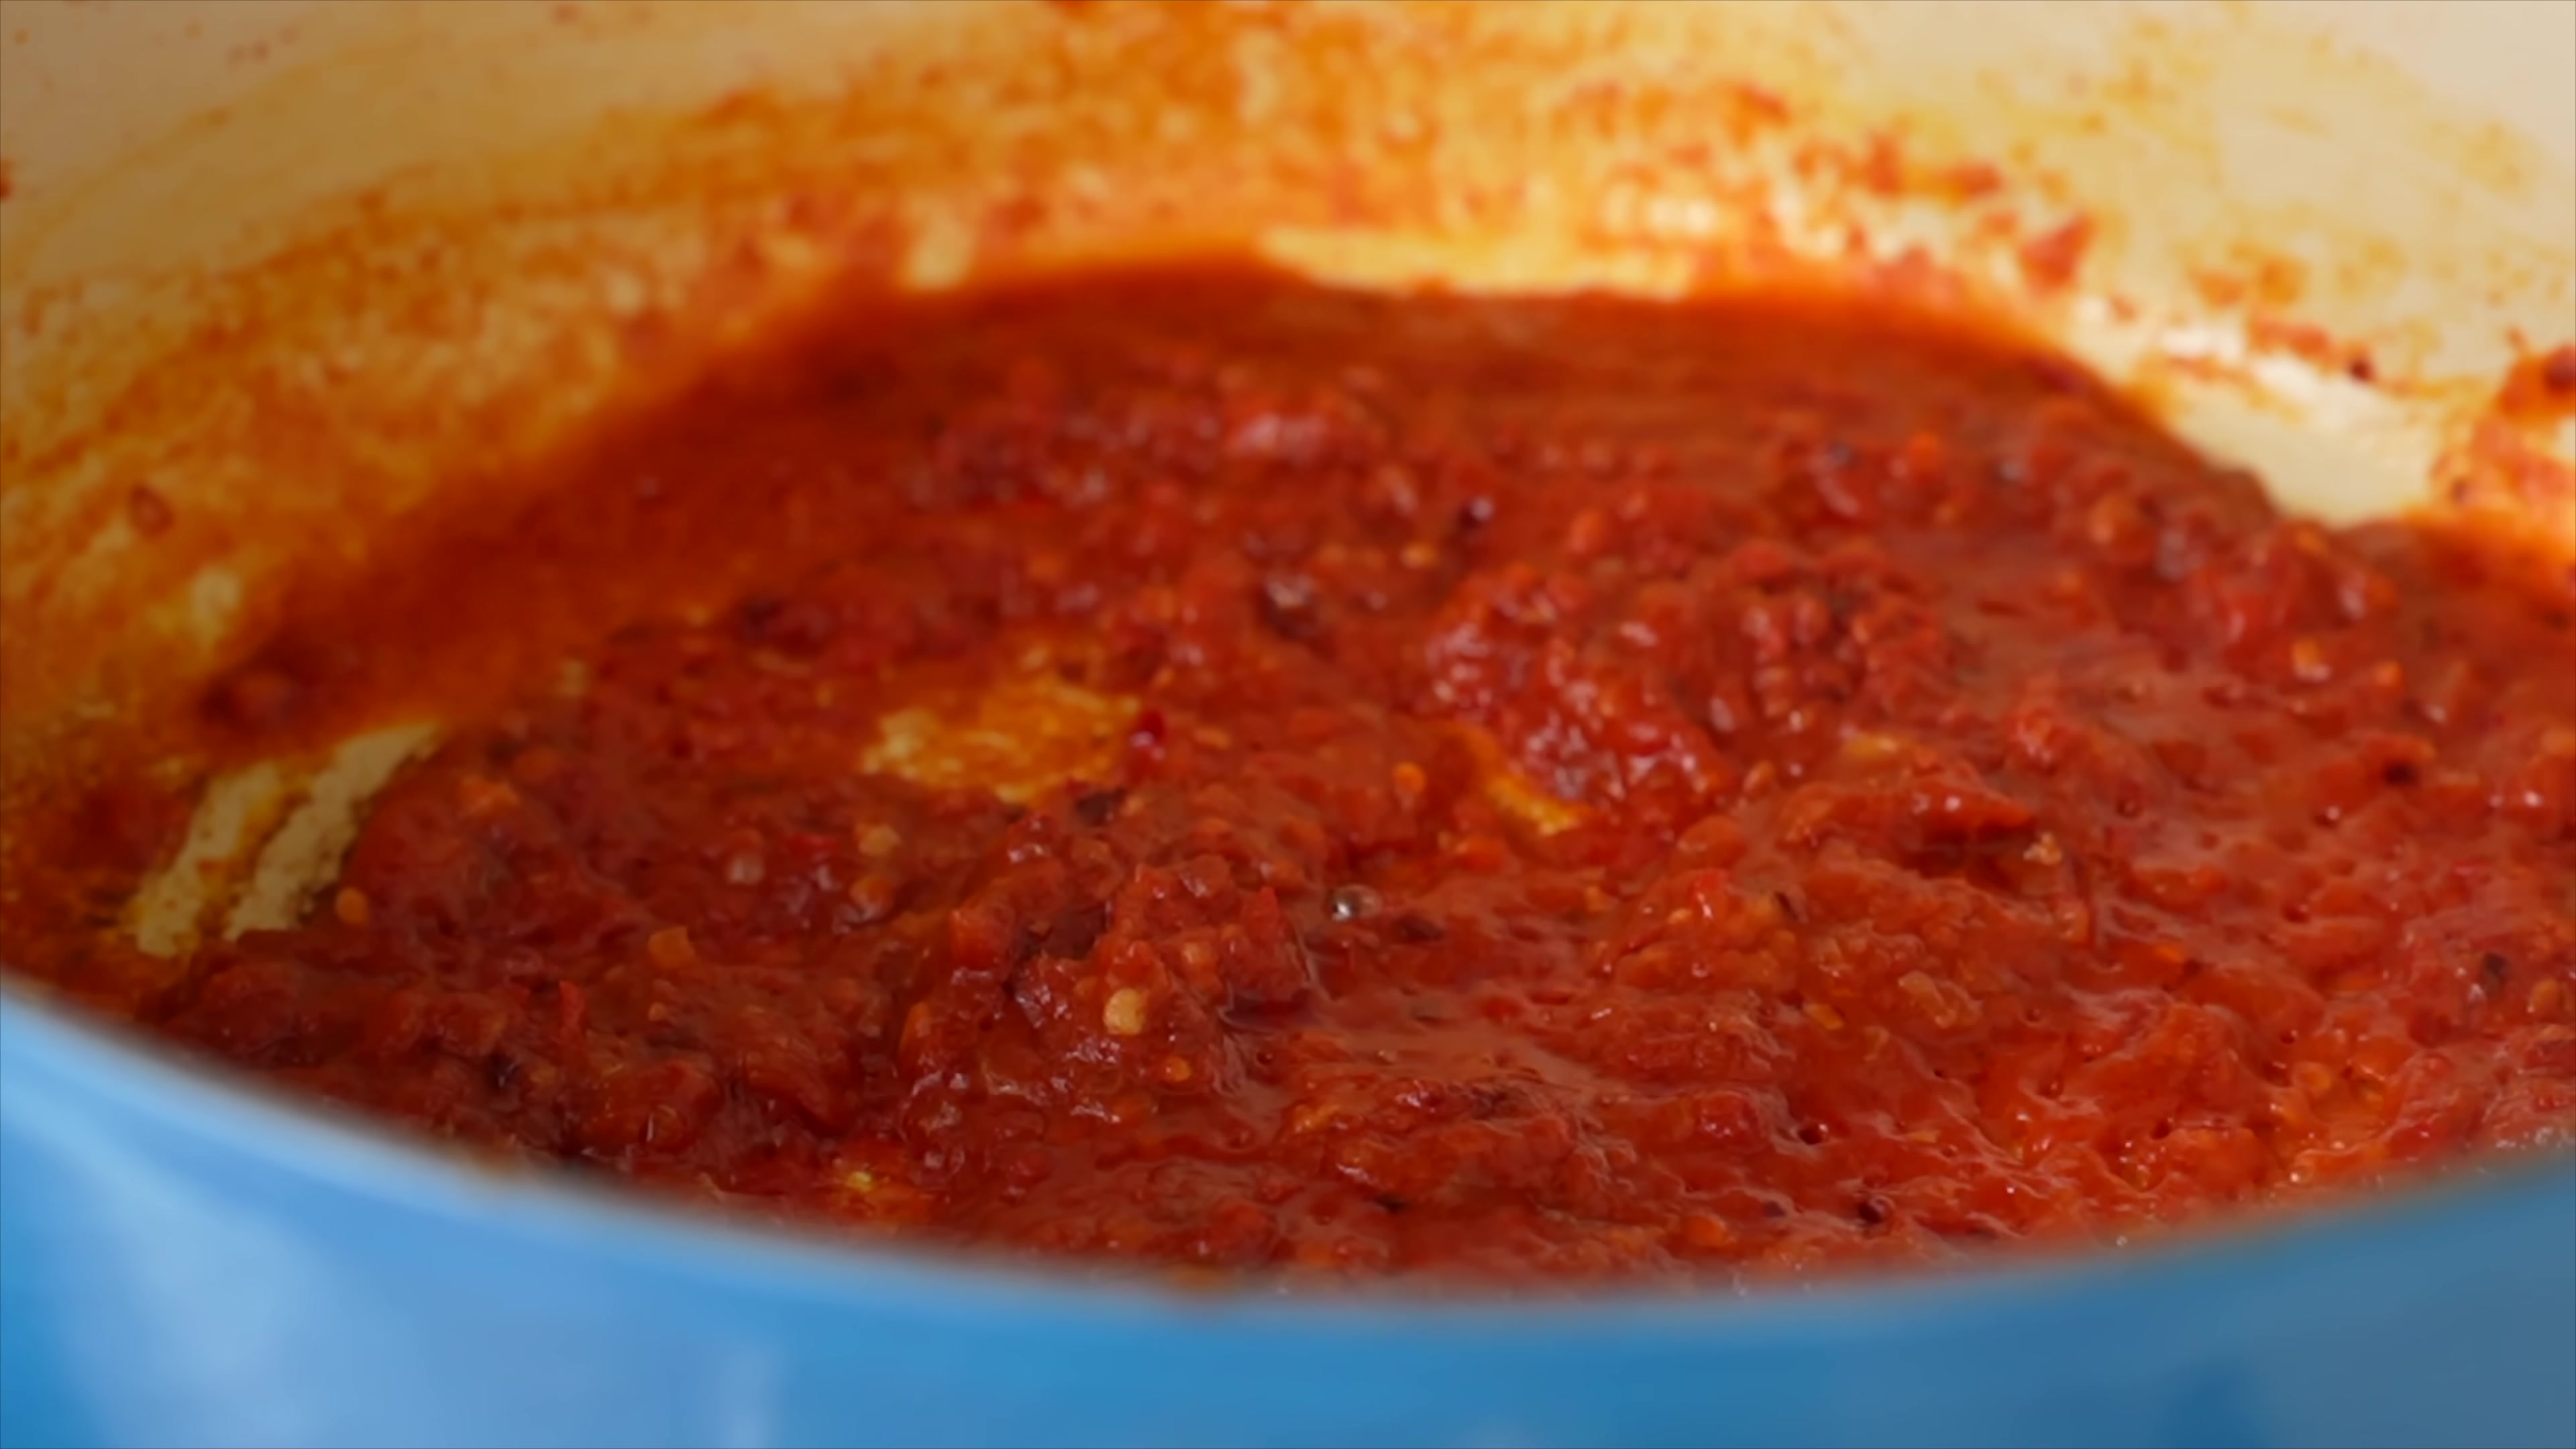

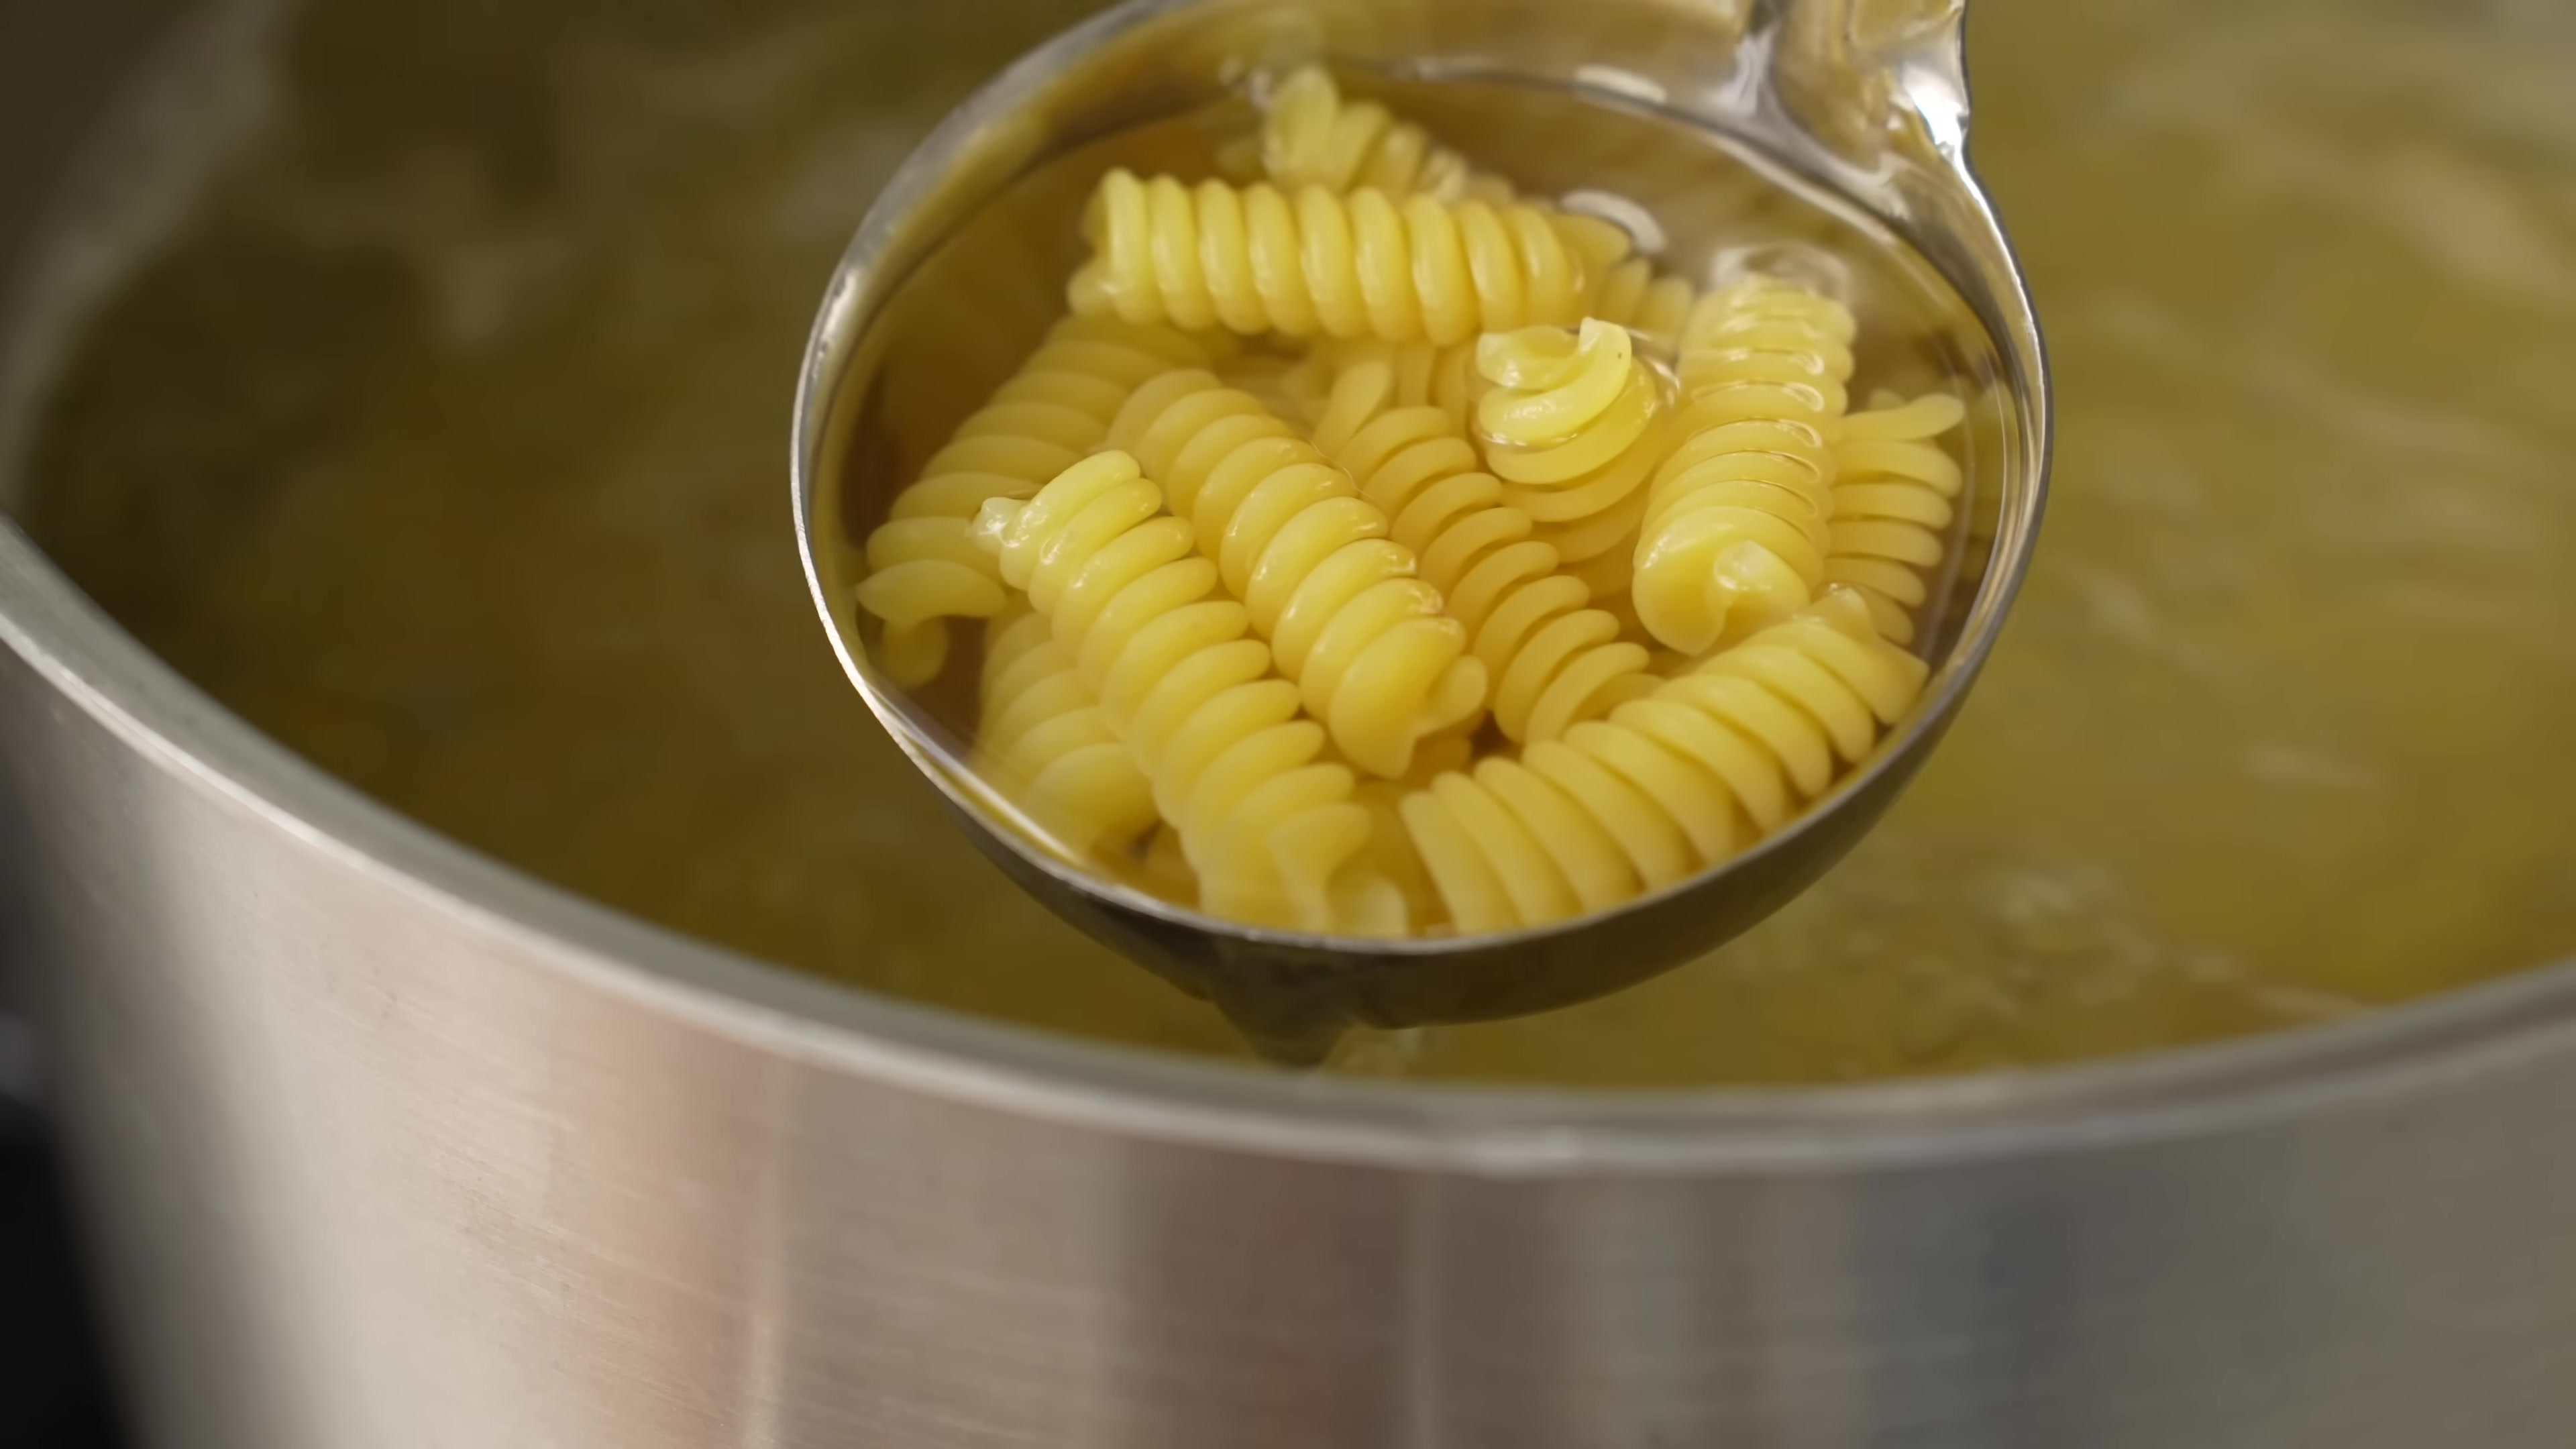

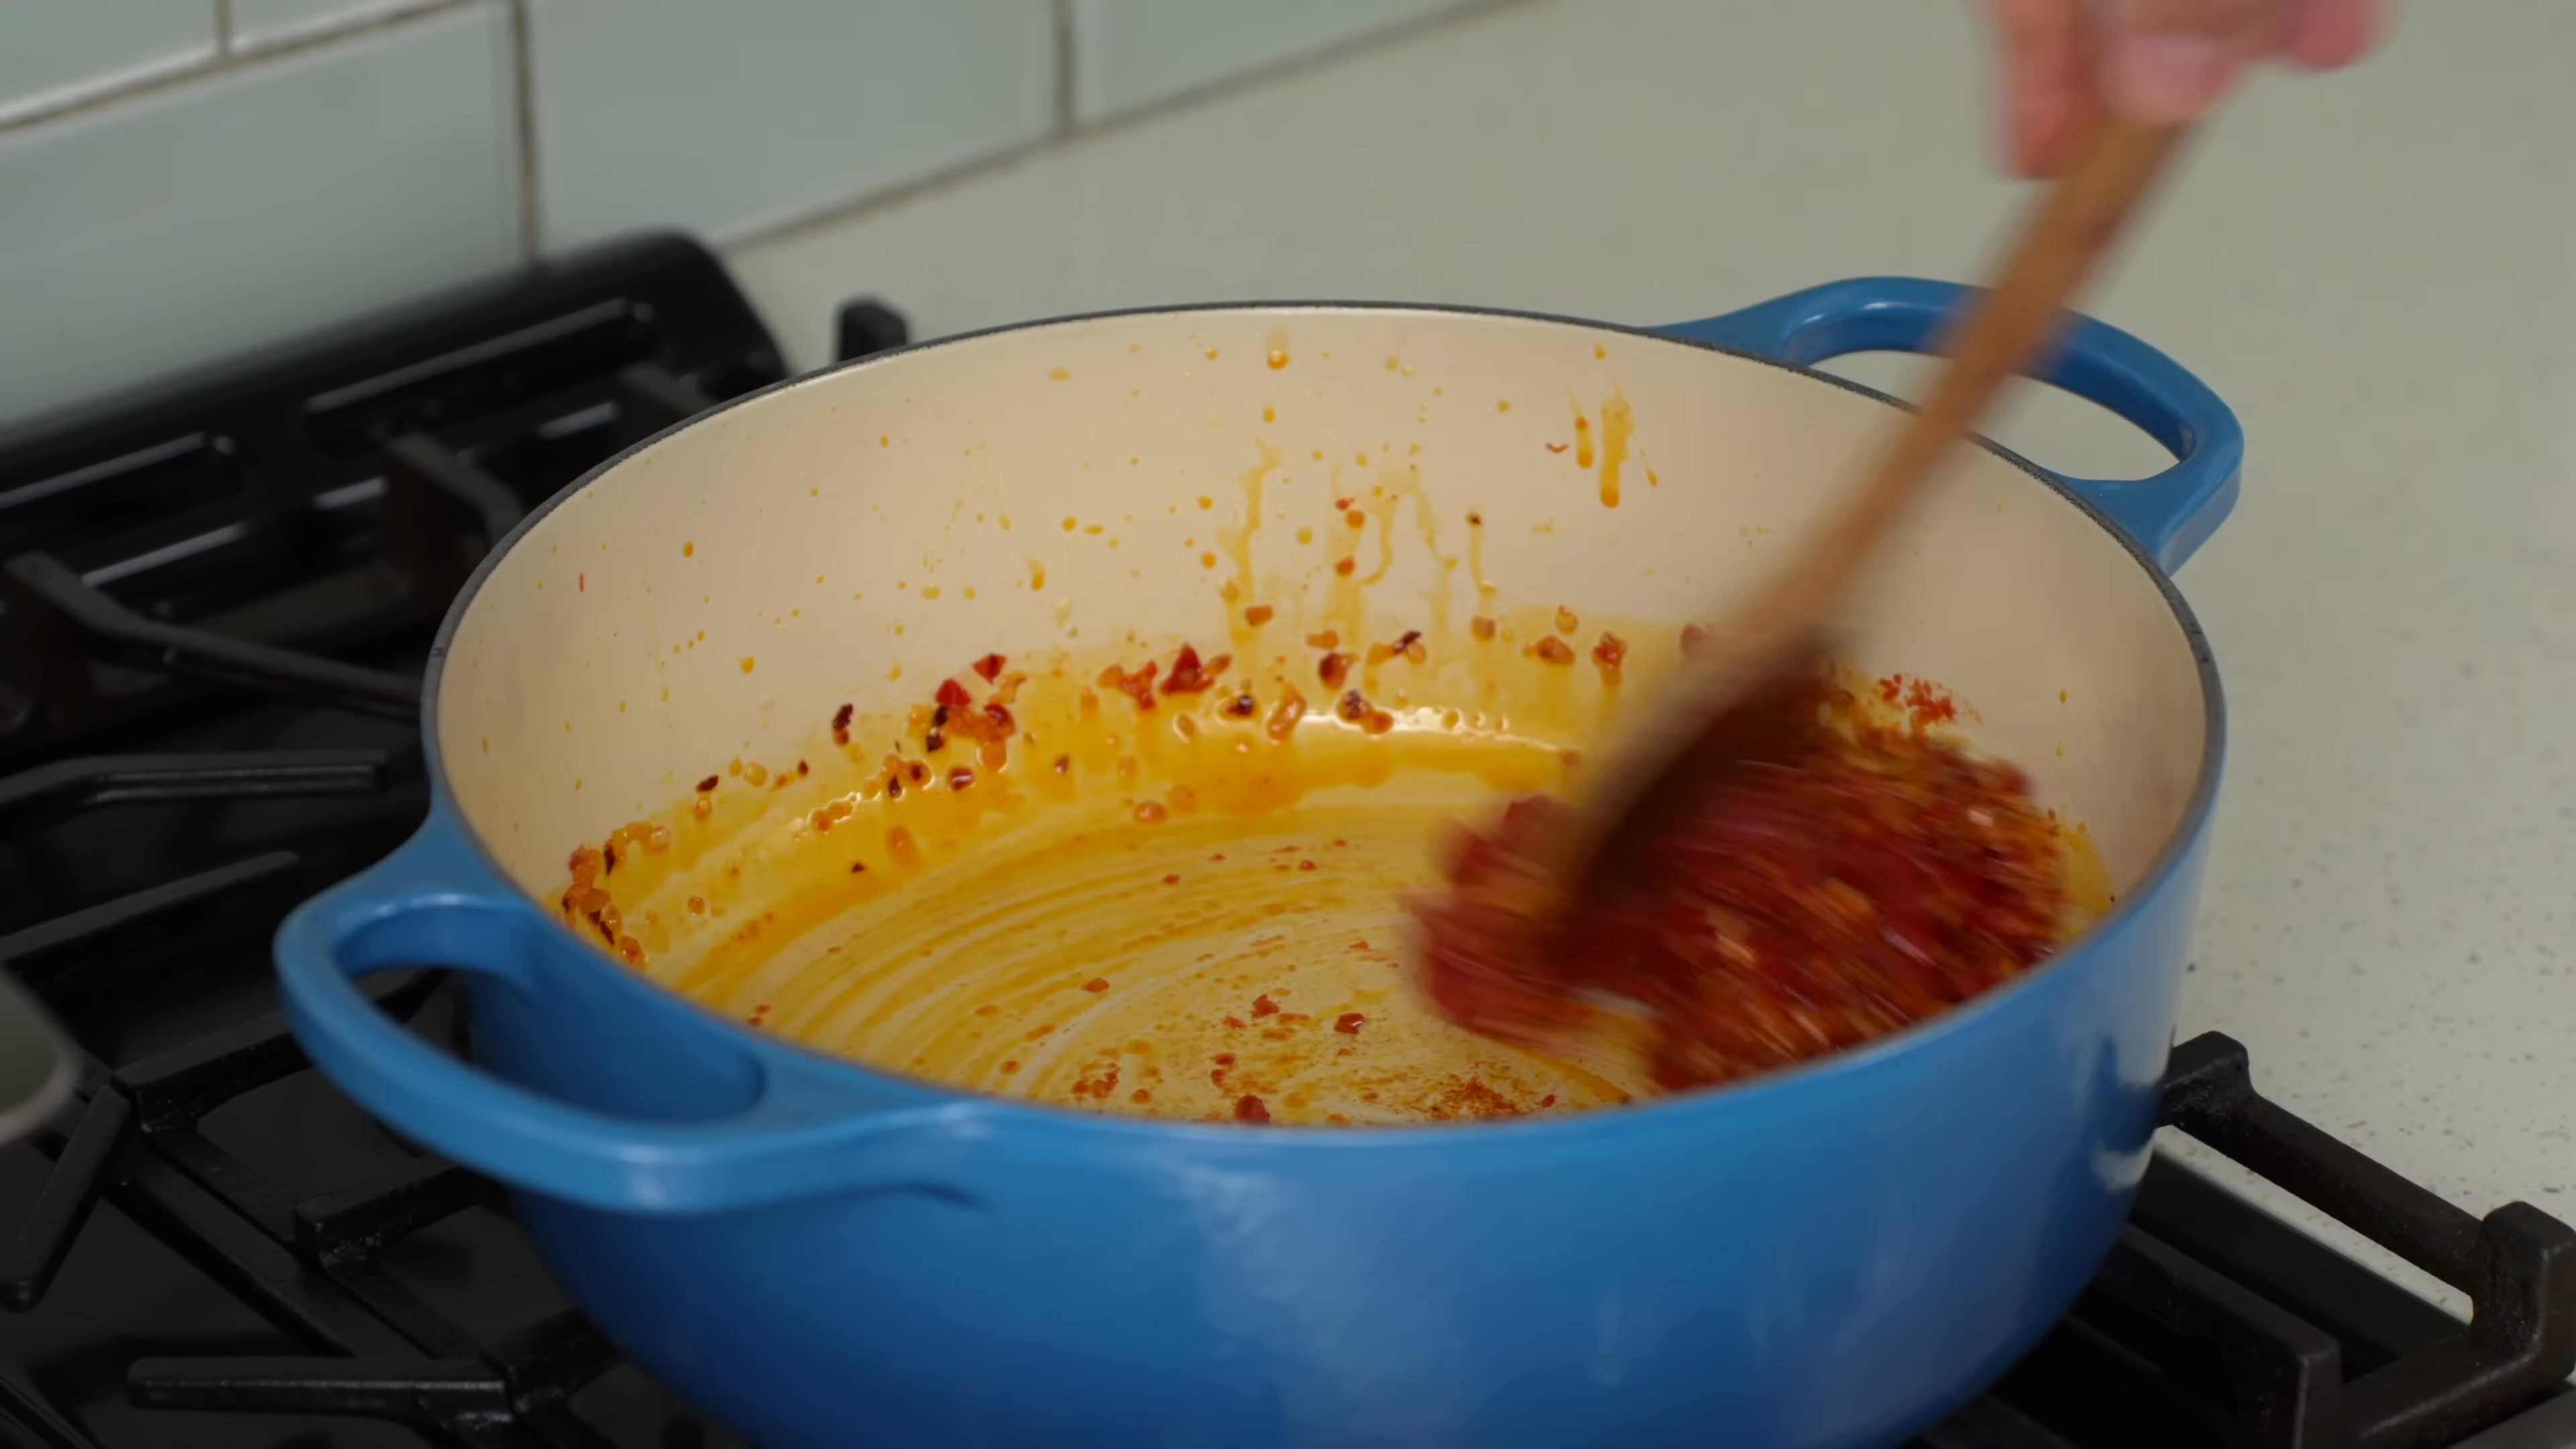

베스트 썸네일 저장: output/best_thumbnail.jpg


In [16]:
from IPython.display import display, HTML, Image as IPyImage
import os, re
from PIL import Image

def path_to_seconds(p, interval=10):
    m = re.search(r'(\d+)', os.path.basename(p))
    idx = int(m.group(1)) if m else 1
    return (idx-1) * interval

def sec_to_hms(sec):
    h = sec // 3600; m = (sec % 3600) // 60; s = sec % 60
    return f"{int(h):02d}:{int(m):02d}:{int(s):02d}"

best_path = None
display(HTML("<h3>Top-5 Recommended Thumbnails</h3>"))

for rank, (p, s) in enumerate(results, 1):
    ts = sec_to_hms(path_to_seconds(p, interval_sec))
    display(HTML(f"<b>Top{rank}</b> | score={s:.3f} | time={ts}"))
    display(IPyImage(filename=p, width=480))

    if rank == 1:
        best_path = p

# best 썸네일 저장
if best_path:
    import os
    os.makedirs("output", exist_ok=True)
    out_best = "output/best_thumbnail.jpg"
    Image.open(best_path).save(out_best)
    print("베스트 썸네일 저장:", out_best)


In [22]:
from PIL import Image
import torch
import glob
image_paths = sorted(glob.glob("frames/*.jpg"))

image_list = [Image.open(p).convert("RGB") for p in image_paths]

image_inputs = clip_processor(images=image_list, return_tensors="pt", padding=True).to(device)
image_features = clip_model.get_image_features(**image_inputs)

# L2 정규화 - 코사인 유사도 계산용
image_features = image_features / image_features.norm(dim=-1, keepdim=True)



제목: Pasta recipe for beginners
→ 베스트 썸네일: frames/frame_00018.jpg


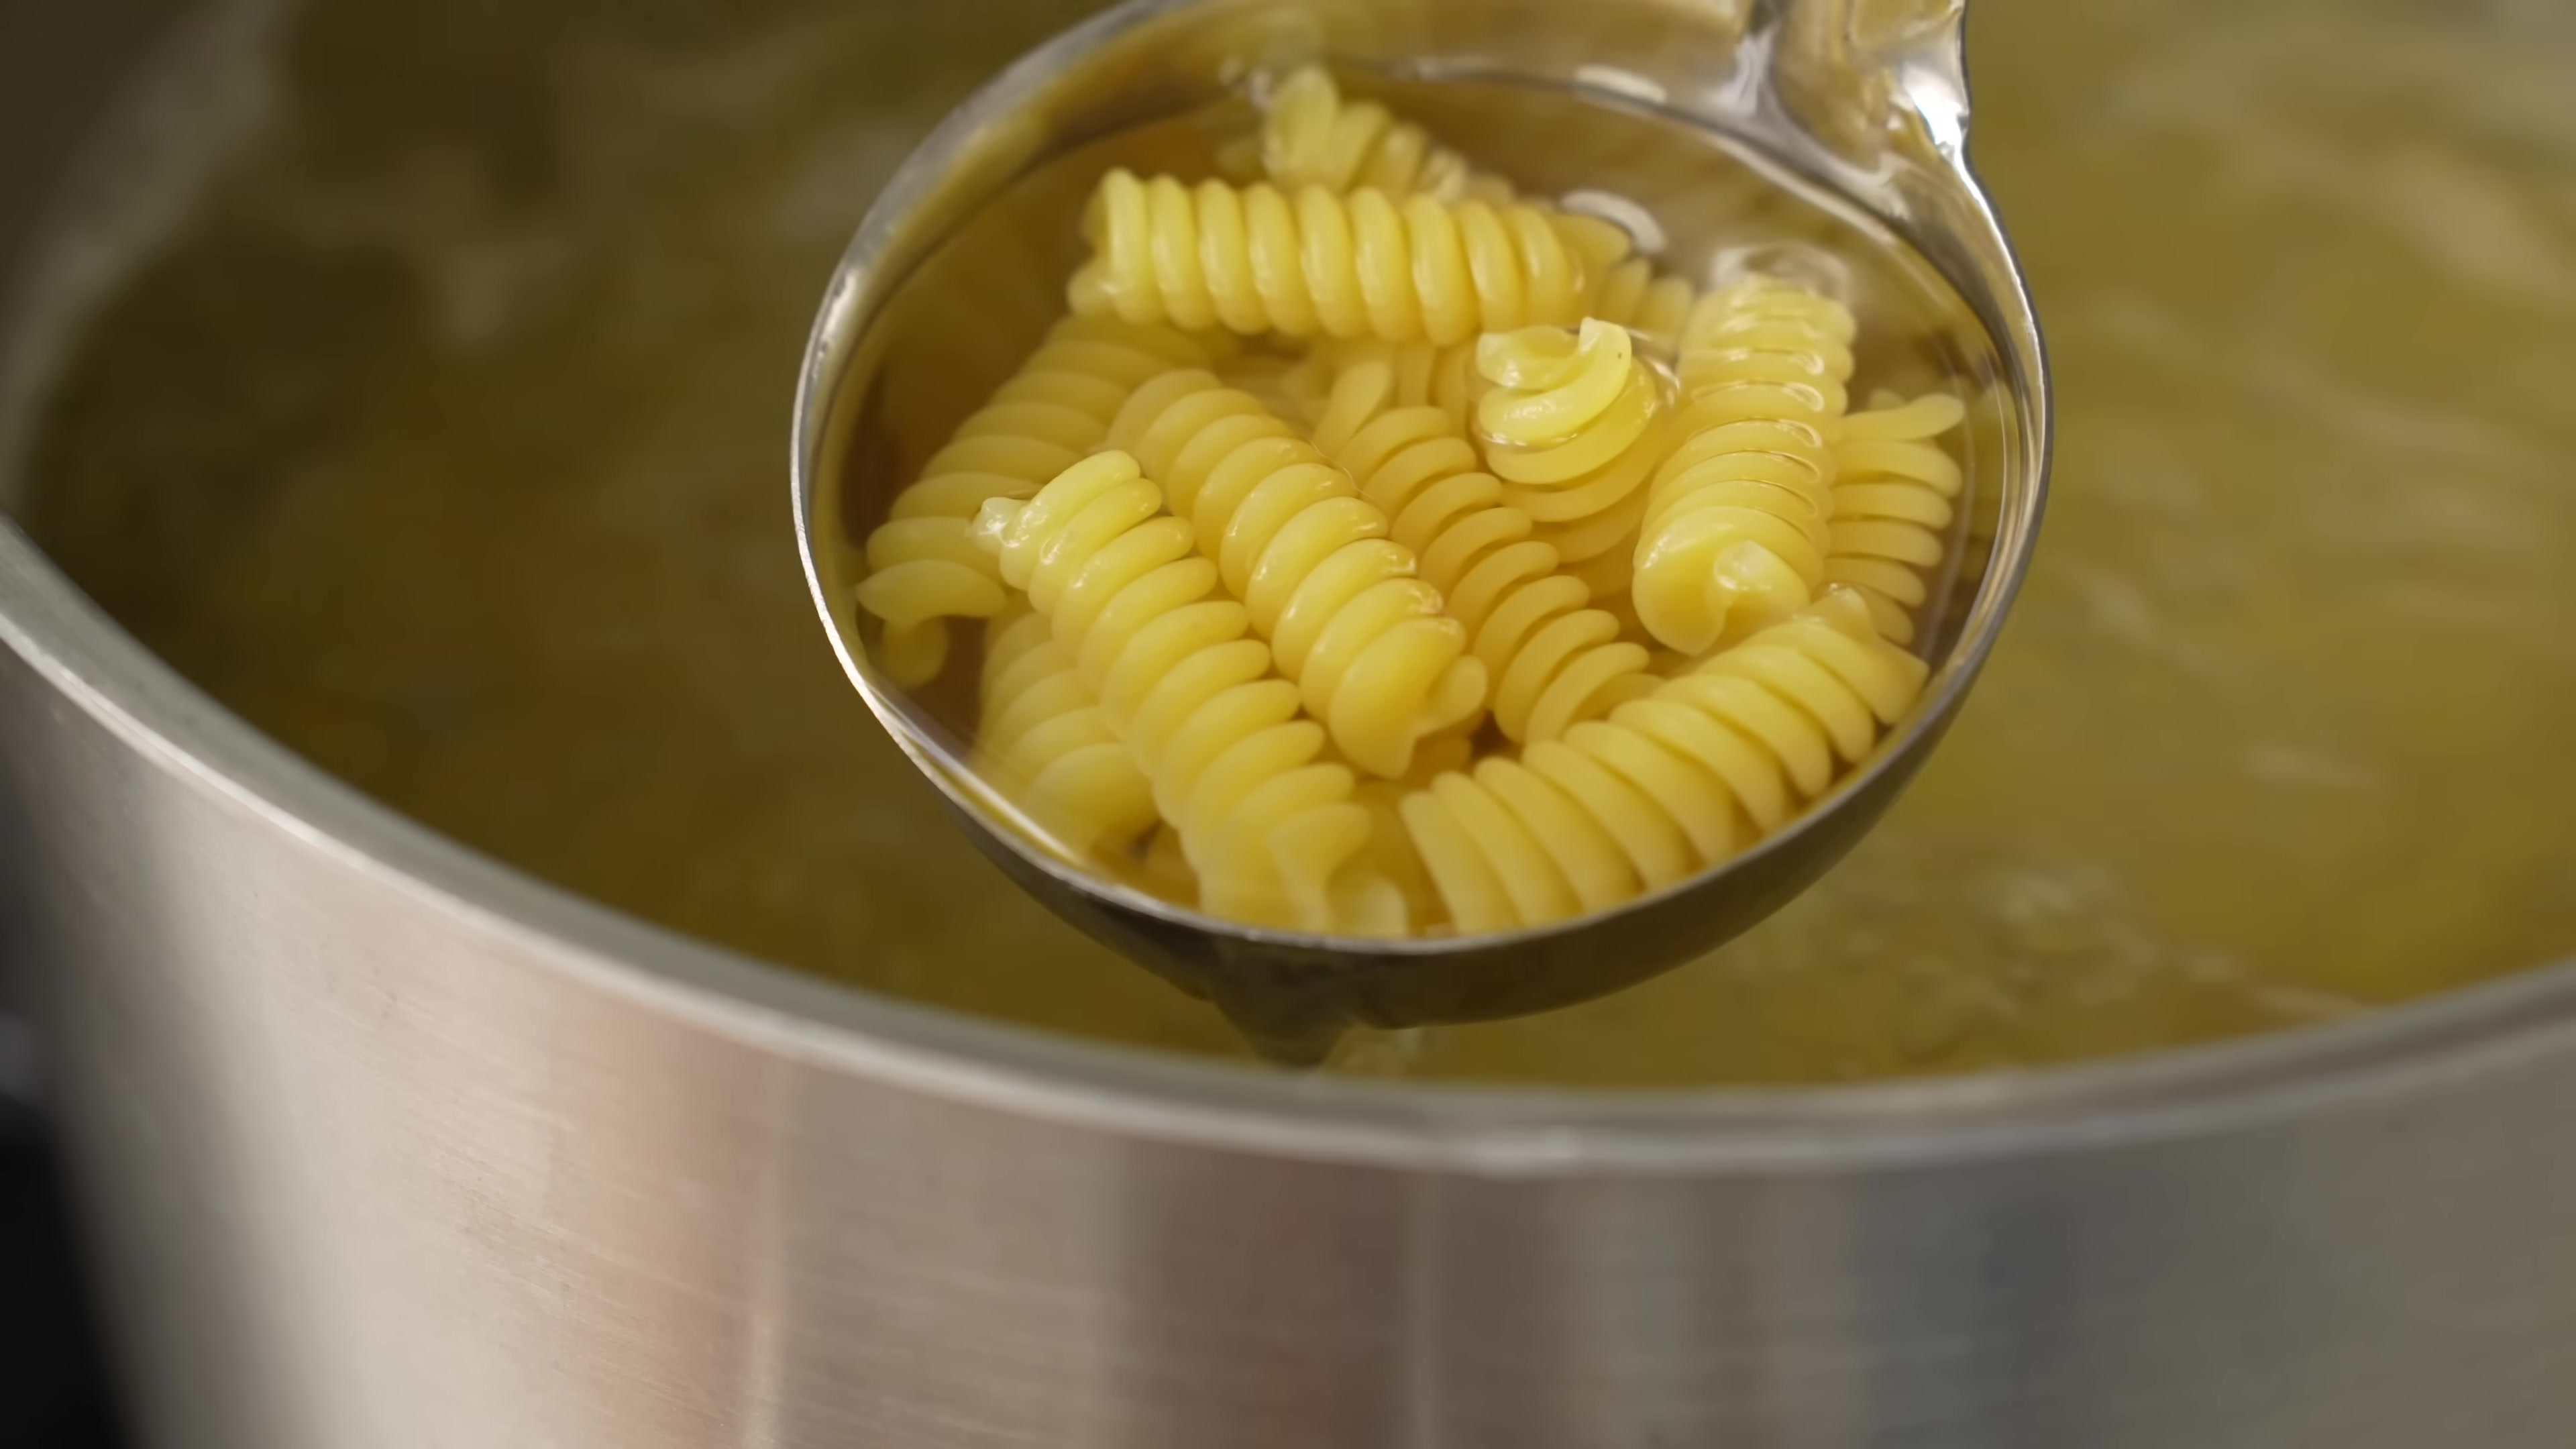


제목: Creamy carbonara sauce
→ 베스트 썸네일: frames/frame_00081.jpg


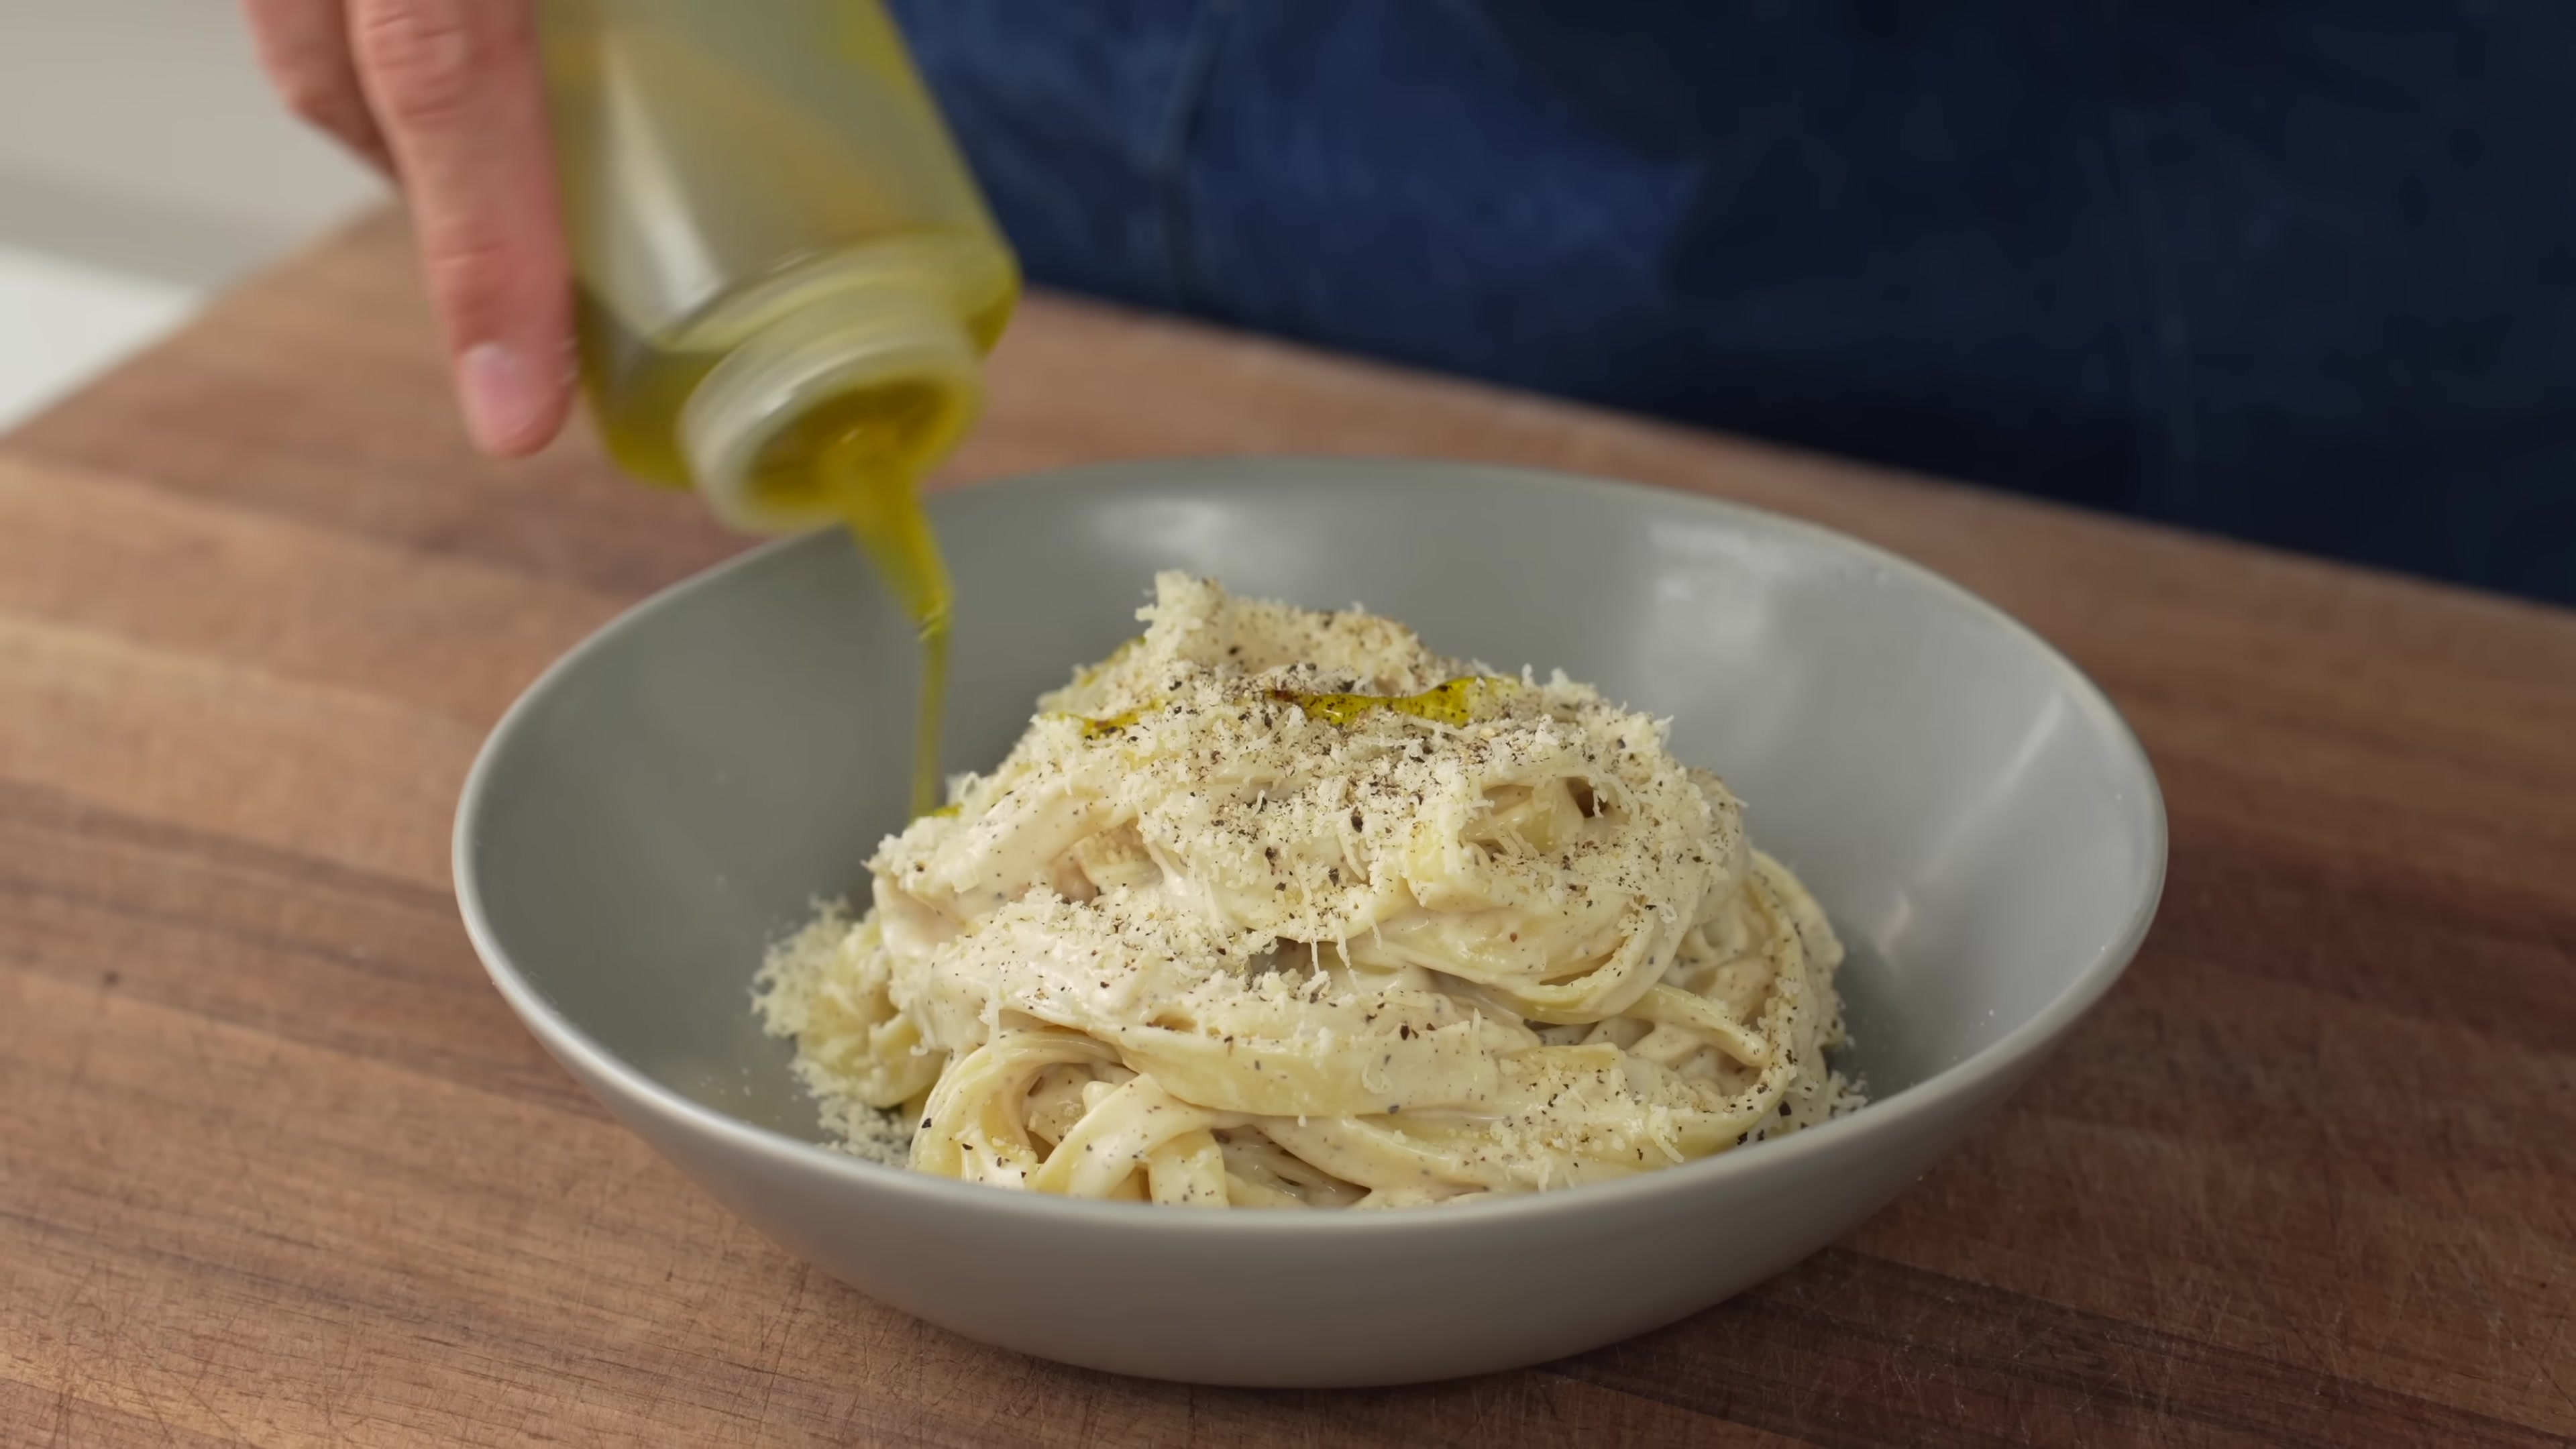


제목: Quick tomato pasta
→ 베스트 썸네일: frames/frame_00045.jpg


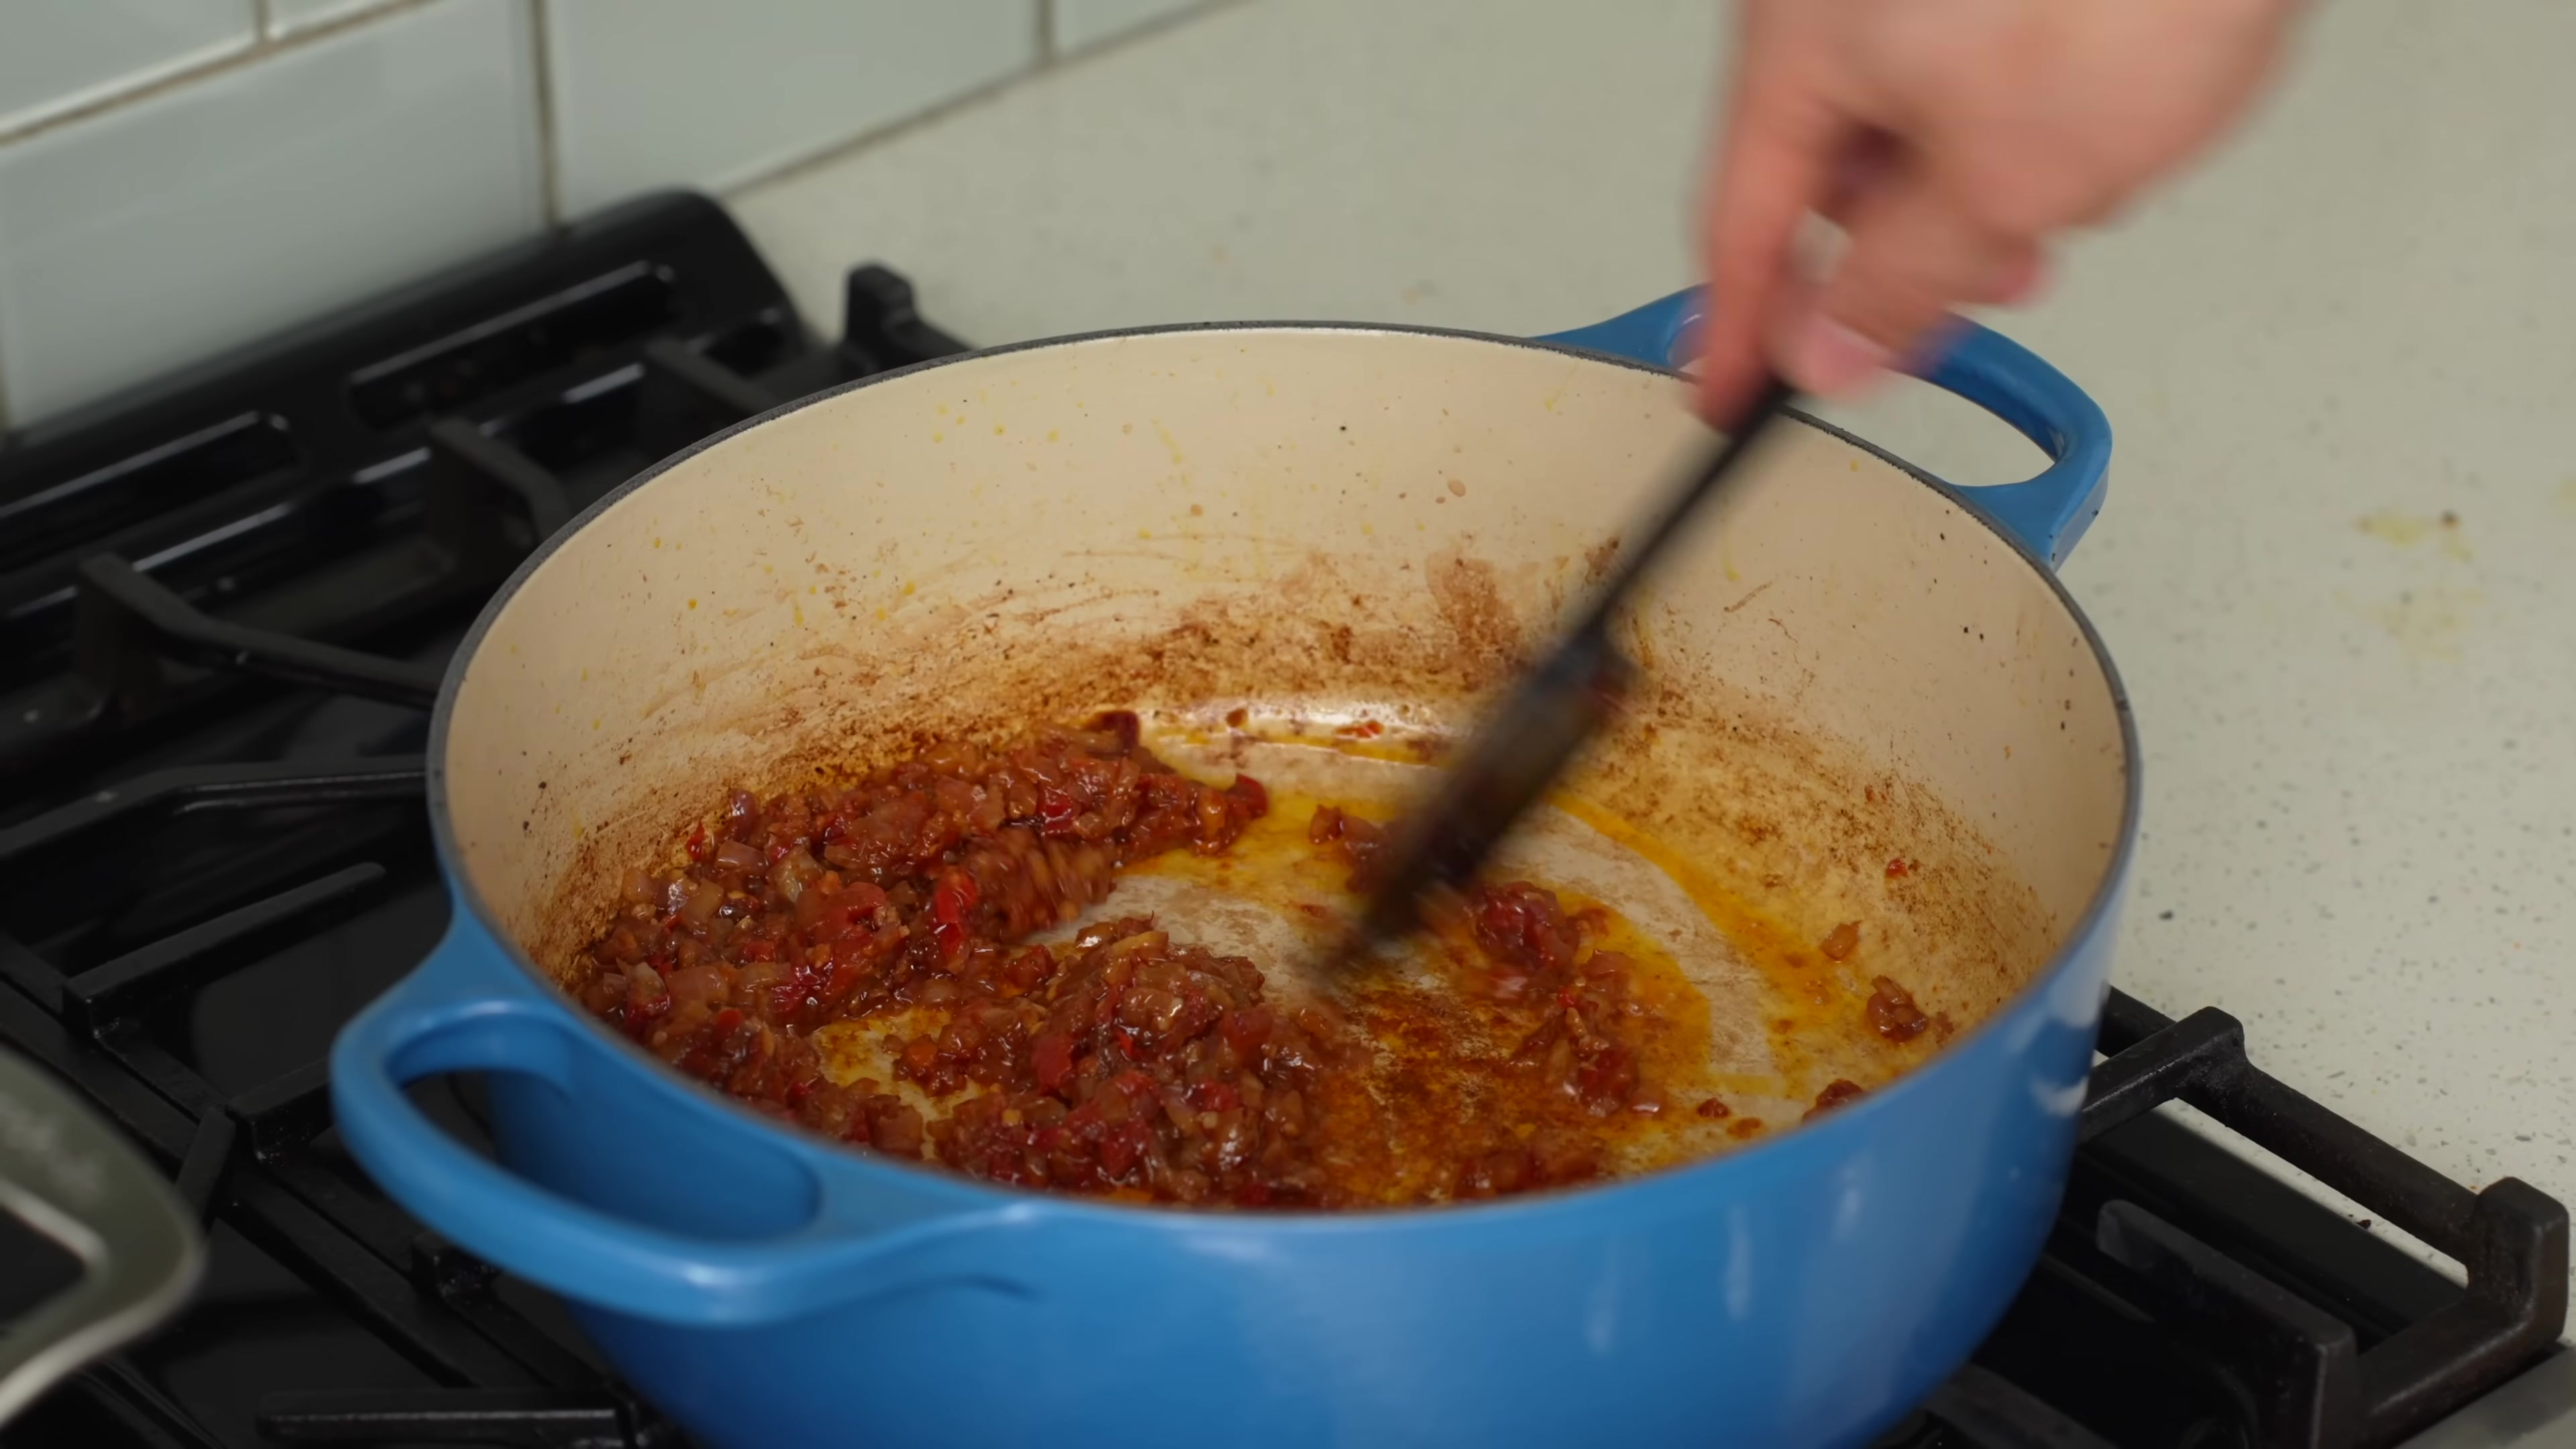

In [26]:
titles = [
    "Pasta recipe for beginners",
    "Creamy carbonara sauce",
    "Quick tomato pasta"
]

for t in titles:
    text_inputs = clip_processor(text=[t], return_tensors="pt", padding=True).to(device)
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    sims = (image_features @ text_features.T).squeeze(1)
    best_idx = sims.argmax().item()
    print(f"\n제목: {t}")
    print(f"→ 베스트 썸네일: {image_paths[best_idx]}")
    display(IPyImage(filename=image_paths[best_idx], width=480))

## 옵션: 개선 아이디어
- **다양성 보정**: 상위 30장 중 pHash/SSIM으로 유사 프레임 제거 후 Top‑k 선택
- **제목 전처리**: 불용어 제거, 핵심 키워드(명사/동사)만 남기기
- **가중치 혼합**: 얼굴 검출/텍스트 박스 검출 점수와 가중 평균하여 클릭 유도력 향상
